# Introduction

In the following notebook, I will be performing an EDA of some Airbnb data in the San Francisco area. This data pertains to the last calendar year, which at the time of this analysis would be December 2018 - December 2019.

In the following analysis, I will be looking to explore the data and answer the following questions:

- Based on the reviews of the last year, what makes a good user experience at a Airbnb rental? What makes a poor user experience? What would you advise to new Airbnb hosts to ensure high reviews and consistent renters?
- What are some of the seasonal Airbnb trends you've noticed in the San Francisco area? When are the down months over the last year? Which months are the most busy? Which areas were the most popular during these times? How have prices changed over time?
- Are airbnb's that are available for monthly rent competitive with the local markets?
- Can you create a price predictor for listings price? What features allows renters to charge more?


*GitHub Repo References*
The raw data files can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Data/01_Raw).

The raw data aggregation scripts can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Project%20Codes/01.%20Raw%20Data%20Aggregation%20Scripts).

The data cleaning scripts used to tidy the raw data aggregation can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Project%20Codes/02.%20Data%20Cleaning%20Scripts).

In [56]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd
import pandas_profiling

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [58]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set float format
pd.options.display.float_format = '{:.0f}'.format

#Ignore warnings
import warnings; warnings.simplefilter('ignore')

**Read in Data**

In [59]:
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate/'

In [60]:
#Read in Airbnb Listings Data
listings = pd.read_csv(path + '01_04_2020_Listings_Cleaned.csv',index_col=0, low_memory=True, sep=',')

#Read in Airbnb Calendar and Reviews data
calendar = pd.read_csv(path + '01_04_2019_Calendar_Cleaned.csv', sep = ',',
                       parse_dates=['date'], low_memory=True,index_col=0)

In [61]:
#Read in Zillow data
zillow = pd.read_csv(path + '12_29_2019_Zillow_Cleaned.csv', parse_dates=['Date'],
                     index_col=0, sep=',')

# Data Preview

**Airbnb Listings Data**

In [62]:
#Preview listings data
display(listings.head())

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,jurisdiction_names,last_review,latitude,longitude,market,maximum_maximum_nights,name,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,space,summary,transit,zipcode,weekly_price,monthly_price
0,3,TV Cable TV Internet Wifi Kitchen Pets liv...,0,77,1,Real Bed,1,2,1,0,0,2019-04-03 00:00:00.000000,NaN,moderate,San Francisco,100,New update: the house next door is under const...,25,2009-07-23 00:00:00.000000,2,We are a family with 2 boys born in 2009 and 2...,True,1169,True,True,1,"San Francisco, California, United States",Holly,Duboce Triangle,100,within an hour,2008-07-31 00:00:00.000000,email phone facebook reviews kba,* No Pets - even visiting guests for a short t...,958,True,True,"{""SAN FRANCISCO""}",2019-03-16 00:00:00.000000,38,-122,San Francisco,30,"Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Western Addition,183,51,170,Apartment,False,False,True,10,10,10,10,10,97,10,2,Entire home/apt,20190403130253,100,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,94117,1120,4200
1,5,Internet Wifi Kitchen Heating Family/kid fri...,0,0,1,Real Bed,2,3,1,0,0,2019-04-03 00:00:00.000000,NaN,strict_14_with_grace_period,San Francisco,100,We live in a large Victorian house on a quiet ...,0,2009-05-03 00:00:00.000000,2,Philip: English transplant to the Bay Area and...,True,8904,True,False,2,"San Francisco, California, United States",Philip And Tania,Bernal Heights,80,within a day,2009-03-02 00:00:00.000000,email phone reviews kba work_ema...,"Please respect the house, the art work, the fu...",5858,False,True,"{""SAN FRANCISCO""}",2017-08-06 00:00:00.000000,38,-122,San Francisco,60,Creative Sanctuary,I love how our neighborhood feels quiet but is...,Bernal Heights,111,0,235,Apartment,False,False,True,10,10,10,10,10,98,9,1,Entire home/apt,20190403130253,nan,We live in a large Victorian house on a quiet ...,NaN,The train is two blocks away and you can stop ...,94110,1600,5500
2,2,TV Internet Wifi Kitchen Free street parking...,30,365,4,Real Bed,1,1,9,9,0,2019-04-03 00:00:00.000000,NaN,strict_14_with_grace_period,San Francisco,50,Nice and good public transportation. 7 minute...,12,2009-08-31 00:00:00.000000,1,7 minutes walk to UCSF. 15 minutes walk to US...,True,21994,True,False,10,"San Francisco, California, United States",Aaron,Cole Valley,100,within a few hours,2009-06-17 00:00:00.000000,email phone reviews jumio govern...,"No party, No smoking, not for any kinds of smo...",7918,False,True,"{""SAN FRANCISCO""}",2016-11-21 00:00:00.000000,38,-122,San Francisco,60,A Friendly Room - UCSF/USF - San Francisco,"Shopping old town, restaurants, McDonald, Whol...",Haight Ashbury,17,0,65,Apartment,False,False,True,8,9,8,9,9,85,8,0,Private room,20190403130253,200,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,N Juda Muni and bus stop. Street parking.,94117,485,1685
3,2,TV Internet Wifi Kitchen Free street parking...,30,365,4,R

**Airbnb Calendar Data**

In [63]:
#Preview calendar data
display(calendar.head())

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,80,0,2019-04-03,187730,120,3,80
1,80,0,2019-04-04,187730,120,3,80
2,82,1,2019-04-05,187730,120,3,82
3,82,1,2019-04-06,187730,120,3,82
4,81,1,2019-04-07,187730,120,3,81


**Zillow Data**

In [64]:
#Preview zillow data
display(zillow.head())

,City,County,Metro,Zip,State,SizeRank,Bedrooms,Date,Median_Rent
4928,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-03-01,1200
11368,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-04-01,1250
17808,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-05-01,1200
24248,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-06-01,1250
30688,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-07-01,1225


# Data Exploration

- How has Airbnb grown over the last year? Which neighborhoods have shown the most growth?
- What are the metrics for the different neighborhoods in SF?
- Are airbnb's that are available for monthly rent competitive with the local rent market? Is Airbnb a legitmate option to consider for short term living as opposed to finding month to month leases?
- What are the different data distributions for the different outcome variables we are interested in exploring?



#### What are the different data distributions for the different outcome variables we are interested in exploring?


date

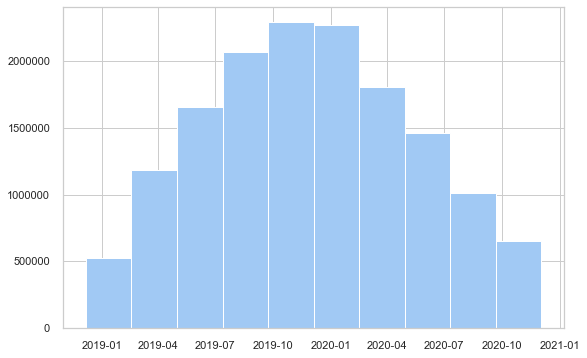

In [65]:
calendar.date.hist()

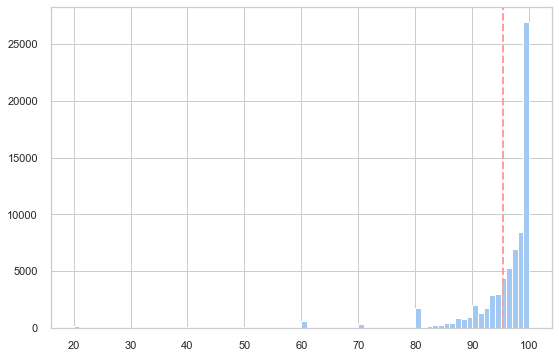

In [66]:
#plot hist
listings.review_scores_rating.hist(bins = 80)

#plot the mean
mean = np.mean(listings.review_scores_rating)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

Listings price

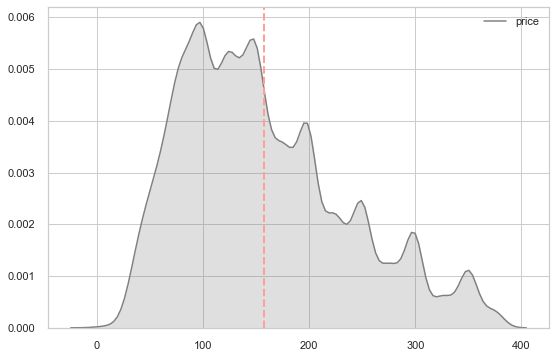

In [67]:
#KDE
ax = sns.kdeplot(listings.price, shade=True, color="grey")

#plot the mean
mean = np.mean(listings.price)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

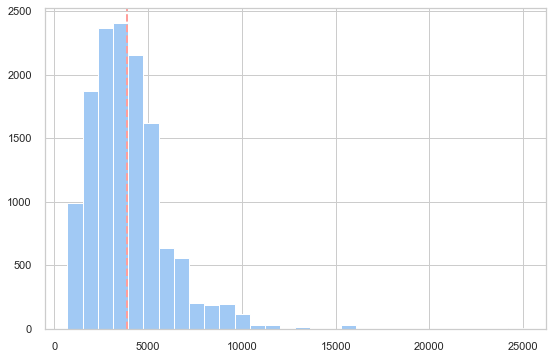

In [68]:
listings.monthly_price.hist(bins = 30)

#plot the mean
mean = np.mean(listings.monthly_price)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

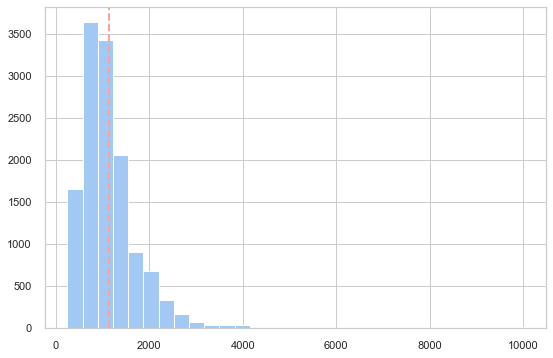

In [69]:
listings.weekly_price.hist(bins = 30)

#plot the mean
mean = np.mean(listings.weekly_price)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

#### How has Airbnb grown over the last year(12/2018 - 12/2019)?

Let's begin by taking a look at the number of unique listings per month available for rent from Airbnb hosts.

In [70]:
#Set date as index for calendar data
calendar.set_index('date', inplace=True)

#Capture appropriate dates for analysis in Calendar data
calendar.loc['2019-12-01':'2020-01-01']

# #Convert calendar to dask
# calendar = dd.from_pandas(calendar, npartitions=3)

#Extract date info from index and assign as columns
calendar['year'] = calendar.index.year
calendar['month'] = calendar.index.month
calendar['weekday'] = calendar.index.weekday_name

#Check
calendar()

TypeError: 'DataFrame' object is not callable

In [ ]:
#Group last year by month_year and get a count of unique listings per day
last_year_daily = calendar.groupby(['date'])['listing_id'].agg({'nunique'}).reset_index()

In [ ]:
# #Rename columns
last_year_daily =last_year_daily.rename(columns = {'nunique': 'listings'})

In [ ]:
last_year_monthly = last_year.reset_index()
last_year_monthly.head()

In [ ]:
last_year_monthly['month_year'] = pd.to_datetime(last_year_monthly['date']).dt.to_period('M') #would this work in time series?
last_year_monthly = last_year_monthly.groupby('month_year')['listing_id'].agg({'nunique'}).reset_index()

# #Rename columns
last_year_monthly =last_year_monthly.rename(columns = {'nunique': 'listings'})

In [ ]:
#Set 538 plot style
plt.style.use('fivethirtyeight')


#Plot daily unique listings data
ax = last_year_daily.plot(x='date', y='listings', kind = 'line',style='o-', markersize=.5,
          label= 'Daily Unique Listings',figsize = (15,10),
         linewidth = 1.5)
 
#plot montly average
last_year_monthly.plot(x='month_year', y='listings',kind = 'line',style='o-', markersize= 10,
          label= 'Monthly Unique Listings',
         linewidth = 1.5 , ax=ax)

#Set fontdict
fontdict={'weight' : 'bold',
          'size': 17}

#Set x and y labels
ax.set_xlabel('Month',fontdict=fontdict)
ax.set_ylabel('Count', fontdict=fontdict)

#Format yticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

#Set Title
ax.set_title('Growth of Airbnb Listings in San Francisco', fontweight = 'bold', fontsize=22)

#Adjust plot margins
ax.margins(0,.12)

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Add Text
xs,ys=last_year_monthly['month_year'], last_year_monthly['listings']

for x,y in zip(xs,ys):
    label = '{:,}'.format(y)
    plt.annotate(label, (x,y),textcoords="offset points",fontsize = 9, xytext=(-40,20), ha='center')

#Set legend
plt.legend(title='Legend', frameon = True, loc='upper left');

Over the last year, there has been significant growth in the number of listings available for rent month to month. Let us look into the number of nights booked by users over the last year.

**Growth by neighborhood September 2018 - December 2019**

We'll merge our calendar data with listings data to capture neighborhood data

In [ ]:
#Convert calendar to dask to improve speed on merge
calendar_dd = dd.from_pandas(calendar, npartitions=3)


In [ ]:
#capture listing id and neighbourhood_cleansed from listings for merge
neighborhoods = listings[['id', 'neighbourhood_cleansed']]

calendar_dd = calendar_dd.reset_index()

#Merge with calendar_dd
neighborhood_growth = calendar_dd.merge(neighborhoods, left_on ='listing_id', right_on='id')

#Drop redundant columnsa
neighborhood_growth= neighborhood_growth.drop(columns = ['id'])

In [ ]:
neighborhood_growth=neighborhood_growth[(neighborhood_growth['date'] < '2020-01-01')]

#convert to pandas
neighborhood_growth_pd = neighborhood_growth.compute()

#Group last year by month_year and get a count of unique listings per month
neighborhood_growth_pd = neighborhood_growth_pd.groupby(['neighbourhood_cleansed', 'year', 'month'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
neighborhood_growth_pd =neighborhood_growth_pd.rename(columns = {'neighbourhood_cleansed': 'neighborhoods',
                                                                 'nunique': 'listings'})

In [ ]:
neighborhood_growth_pd = neighborhood_growth_pd.sort_values(by=['year','month', 'listings'], ascending=False)

In [ ]:
#Set fig size
f, ax = plt.subplots(figsize = (6,15))

#set style and color_pallete
sns.set(style='whitegrid')

#Set color codes for modern data
sns.set_color_codes('pastel')

#plot data from 
j = sns.barplot(x = 'listings', y = 'neighborhoods', color = 'b',
            data = neighborhood_growth_pd.loc[(neighborhood_growth_pd.month == 12 ) & 
                                         (neighborhood_growth_pd.year == 2019)],
                label = 'December 2019')

#Set color codes for older data
sns.set_color_codes('dark')

#Plot data from 2018-09
g = sns.barplot(x = 'listings', y = 'neighborhoods', color = 'b',
            data = neighborhood_growth_pd.loc[(neighborhood_growth_pd.month == 12 ) & 
                                         (neighborhood_growth_pd.year == 2018)],
                label = 'December 2018')

#Set legend info
ax.legend(frameon = True, ncol = 2, loc= 'lower center');

#Set Labels
ax.set(ylabel="", xlabel="Airbnb Listings")
ax.set_title('Explosion of Airbnb', fontweight = 'bold', fontsize = 18)


sns.despine(left=True, bottom=True)


**Prices by property type**


In [ ]:
#Set 538 plot style
plt.style.use('ggplot')

#Counts of property types
prop_count = listings.groupby('property_type')['id'].count().sort_values(ascending = False).reset_index()
prop_count.plot(x = 'property_type', y = 'id', kind = 'bar')

In [ ]:
#Get top 15 common prop types
prop_list=list(prop_count.property_type.head(15))

#sort top 15 by median value
test = listings[listings.property_type.isin(prop_list)].groupby('property_type')['price'].median().sort_values(ascending = False).reset_index()

In [ ]:
test_list = test.property_type.tolist()

In [ ]:
#Set 538 plot style
plt.style.use('fivethirtyeight')

#Set Figure
f, ax = plt.subplots(figsize= (10,5))

#Plot
g= sns.boxplot(x="property_type", y="price", order=test_list, 
               width = .4,palette=sns.light_palette((210, 90, 60), input="husl"),
             data=listings[listings.property_type.isin(test_list)], ax=ax)

#Set Title
ax.set_title('15 Most common properties with listing price', fontweight = 'bold', fontsize=22)

#Set x and y Labels
ax.set_ylabel('Price per Night($)',fontdict=fontdict)
ax.set_xlabel('Property Type',fontdict=fontdict)

#Rotate x_ticklabels
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

#Format ticks on y-axis

**Heat map**

In [ ]:
corr = listings.corr()
plt.figure(figsize=(15, 15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,linewidths=.1,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Zillow

In [41]:
zillow.set_index(keys = 'Date', inplace=True)

In [42]:
zillow['Year'] = zillow.index.year
zillow['Month'] = zillow.index.month
zillow['Weekday_Name'] = zillow.index.weekday_name

In [43]:
zillow.head()

,City,County,Metro,Zip,State,SizeRank,Bedrooms,Median_Rent,Year,Month,Weekday_Name
Date,,,,,,,,,,,
2010-03-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200,2010,3,Monday
2010-04-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250,2010,4,Thursday
2010-05-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200,2010,5,Saturday
2010-06-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250,2010,6,Tuesday
2010-07-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1225,2010,7,Thursday


# Time Series Analysis

For this analysis, we will isolate the rows in our Zillow data that are in the zipcode or city of the listings data.

In [44]:
#Capture zip information from listings
listings_zip = list(listings.zipcode.unique())

#Capture city information from listings 
listings_cities = list(listings.city.unique())

#Capture SF Data
sf_zillow = zillow[zillow['Zip'].isin(listings_zip) | zillow['City'].isin(listings_cities)]

#Check
print(sf_zillow.shape)
display(sf_zillow.tail())

(2015, 11)


,City,County,Metro,Zip,State,SizeRank,Bedrooms,Median_Rent,Year,Month,Weekday_Name
Date,,,,,,,,,,,
2019-11-01,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94105,CA,2269,2,5800,2019,11,Friday
2019-11-01,Sausalito,Marin,San Francisco-Oakland-Hayward,94965,CA,2434,2,3650,2019,11,Friday
2019-11-01,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94158,CA,2477,2,5288,2019,11,Friday
2019-11-01,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94110,CA,82,3,5575,2019,11,Friday
2019-11-01,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94115,CA,518,3,6500,2019,11,Friday


In [ ]:
#SF vs rest of US Rent

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (12,5))
sf_zillow.groupby('Date')['Median_Rent'].mean().plot(kind = 'line')

zillow.loc['2011-09-01':'2019-11-01'].groupby(['Date'])['Median_Rent'].mean().plot(x_compat=True, kind = 'line', color= 'g')#green


#We also noted each state's region size ranking, which represents how big it is population-wise;
#California is ranked No. 1 with the largest population of all states, while Wyoming is ranked No. 51
zillow[zillow.SizeRank < 10].loc['2011-09-01':'2019-11-01'].groupby(['Date'])['Median_Rent'].mean().plot(x_compat=True, kind = 'line')

Airbnb monthly rent vs bay area rent 

In [ ]:
#Capture id and monthly_price from listings data for merge with calendar data
to_merge = listings[['id','monthly_price']]



In [ ]:
monthly_listings_dd = calendar_dd.merge(to_merge, left_on='listing_id', right_on='id')

In [ ]:
monthly_listings = monthly_listings_dd.compute()

In [ ]:
test_pd=test_pd[-test_pd.monthly_price.isna()]

test_pd.drop_duplicates(inplace = True)

In [ ]:
#Convert date to month-year format
test_pd
#test_pd['date'] = pd.to_datetime(test_pd['date']).dt.to_period('M')

In [ ]:
test_pd.set_index('date', inplace=True)

In [ ]:
test_pd.sort_index(inplace=True)

In [ ]:
test_pd['Year'] = test_pd.index.year
test_pd['Month'] = test_pd.index.month
test_pd['Weekday Name'] = test_pd.index.weekday_name

In [ ]:
test_pd.head()

In [ ]:
test_pd.loc['2018-09':'2019-12'].groupby('date')['monthly_price'].mean().plot()

In [ ]:
sf_zillow.loc['2018-09':'2019-12'].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line')

In [ ]:
#test_pd.loc['2018-09':'2019-12'].groupby('date')['monthly_price'].mean().plot(kind = 'box')
sns.boxplot(x='Month', y = 'monthly_price', data = test_pd)

In [ ]:
sf_zillow.tail()

In [ ]:
calendar.head()

* Comparing monthly rent of airbnb to zillow

In [ ]:
listings.head(2)

In [ ]:
#test = sf_zillow.groupby(['Bedrooms', 'Date'])['Median_Rent'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10,5))

sf_zillow.groupby("Bedrooms")['Median_Rent'].plot(kind="line", ax=ax)
plt.legend(title='Bedrooms', frameon = True, loc='upper right', labels=['studio', 'single','two','three'])


# Other variables and relationships worth exploring

### Principal Component Analysis